In [1]:
import scipy.linalg as la
from math_functions.Get_state_index import Get_State_index
from main_grape.Grape import Grape
%pylab inline
import random as rd
import time
from IPython import display


Populating the interactive namespace from numpy and matplotlib


In [2]:
total_time = 30.0
steps = 1200



#Defining H0
qubit_state_num = 4
alpha = -0.3
fq = 4.105
ens = 2*np.pi*(fq*np.arange(qubit_state_num)+alpha*(np.arange(qubit_state_num)-1)*(np.arange(qubit_state_num))/2.)


mode_state_num = 3
qm_g1 = 2.*np.pi*0.1 #GHz
mode_freq1 = 5.102 #GHz
mode_ens1 = np.array([ 2*np.pi*ii*(mode_freq1) for ii in np.arange(mode_state_num)])
qm_g2 = 2.*np.pi*0.1 #GHz
#mode_freq2 = 5.327 #GHz
mode_freq2 = 6.0 #GHz
mode_ens2 = np.array([ 2*np.pi*ii*(mode_freq2) for ii in np.arange(mode_state_num)])
state_num = qubit_state_num * (mode_state_num**2)
Q_x   = np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)+np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1)
Q_y   = (0+1j) *(np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)-np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1))
Q_z   = np.diag(ens-ens[0])/(2*np.pi*fq)
M_x = np.diag(np.sqrt(np.arange(1,mode_state_num)),1)+np.diag(np.sqrt(np.arange(1,mode_state_num)),-1)
I_q = np.identity(qubit_state_num)
I_m = np.identity(mode_state_num)
H_q = np.diag(ens-ens[0])
H_m1 = np.diag(mode_ens1)
H_m2 = np.diag(mode_ens2)
H0 = np.kron(H_q,np.kron(I_m,I_m)) + np.kron(I_q,np.kron(H_m1,I_m)) +\
        np.kron(I_q,np.kron(I_m,H_m2)) + qm_g1*np.kron(Q_x,np.kron(M_x,I_m)) +\
        qm_g2*np.kron(Q_x,np.kron(I_m,M_x))
#H0 = np.zeros([state_num,state_num])
#Defining Dressed information for our multimode exp        
w_c, v_c = la.eig(H0)
dressed=[]
D= True
if D:
    for ii in range (len(v_c)):
        index=np.argmax(np.abs(v_c[:,ii]))
        if index not in dressed:
            dressed.append(index)
        else:
            temp= (np.abs(v_c[:,ii])).tolist()
            while index in dressed:

                temp.remove(max(temp))
                index2= np.argmax(np.array(temp))

                if index2<index:
                            #dressed.append(index2)
                    index=index2
                else:
                            #dressed.append(index2-1)
                    index=index2+1
            dressed.append(index)

#Defining Forbidden sates
states_h = range(3*mode_state_num**2,4*mode_state_num**2)
states_gef02 = [2,mode_state_num**2+2,2*mode_state_num**2+2]
states_gef20 = [2*mode_state_num,mode_state_num**2+2*mode_state_num,2*mode_state_num**2+2*mode_state_num]
states_forbidden_list = states_h + states_gef02 + states_gef20

#Defining Concerned states (starting states)
psi0 = [0,1,mode_state_num,mode_state_num+1]

#Defining states to include in the drawing of occupation
states_draw_list = [0,1,mode_state_num,mode_state_num+1,mode_state_num**2]
states_draw_names = ['g00','g01','g10','g11','e00']

#Defining U (Target)
g11=Get_State_index(mode_state_num+1,dressed)
g10=Get_State_index(mode_state_num,dressed)

print g11,g10

if D:
    Ct_c= np.identity(state_num) - np.outer(v_c[:,g10], np.conjugate((v_c[:,g10])))
    Ct_c= Ct_c - np.outer(v_c[:,g11], np.conjugate((v_c[:,g11])))
    Ct_c= Ct_c + np.outer(v_c[:,g10], np.conjugate((v_c[:,g11])))
    Ct_c= Ct_c + np.outer(v_c[:,g11], np.conjugate((v_c[:,g10])))
else:
    #Ut_c = la.expm((0-1j)*total_time*H0)
    #Ct_c = Ut_c.copy()
    Ct_c = np.identity(state_num)
    Ct_c[g11,g10] = 1
    Ct_c[g10,g11] = 1
    Ct_c[g10,g10] = 0
    Ct_c[g11,g11] = 0
U = Ct_c

#Defining U0 (Initial)
q_identity = np.identity(qubit_state_num)
m_identity = np.identity(mode_state_num)
U0= np.kron(q_identity,np.kron(m_identity,m_identity))

#Defining control Hs
XI = np.kron(Q_x,np.kron(I_m,I_m))
ZI = np.kron(Q_z,np.kron(I_m,I_m))
YI = np.kron(Q_y,np.kron(I_m,I_m))
Hops = [XI,YI,ZI]
ops_max_amp = [4.0,4.0,4*np.pi]
Hnames =['x','y','z']

#Defining convergence parameters
max_iterations = 5000
decay = max_iterations/2
convergence = {'rate':0.002, 'update_step':20, 'max_iterations':max_iterations,\
               'conv_target':1e-8,'learning_rate_decay':decay}
reg_coeffs = {'alpha' : 0.001, 'z':0, 'dwdt':0.001,'d2wdt2':0.001*0.001, 'inter':100.0}
multi_mode = {'dressed':dressed, 'vectors':v_c, 'qnum':qubit_state_num, 'mnum': mode_state_num,\
              'f':fq, 'es':w_c, 'g1':qm_g1, 'D':D, 'Interpolation':False, 'Modulation':False}
u0 = []
u0.append( 2*np.ones(steps))
u0.append( 0.1*np.ones(steps))

print psi0
print H_q
print H_m1
print H_m2

12 7
[0, 1, 3, 4]
[[  0.           0.           0.           0.        ]
 [  0.          25.79247569   0.           0.        ]
 [  0.           0.          49.69999578   0.        ]
 [  0.           0.           0.          71.72256028]]
[[  0.           0.           0.        ]
 [  0.          32.05681144   0.        ]
 [  0.           0.          64.11362287]]
[[  0.           0.           0.        ]
 [  0.          37.69911184   0.        ]
 [  0.           0.          75.39822369]]


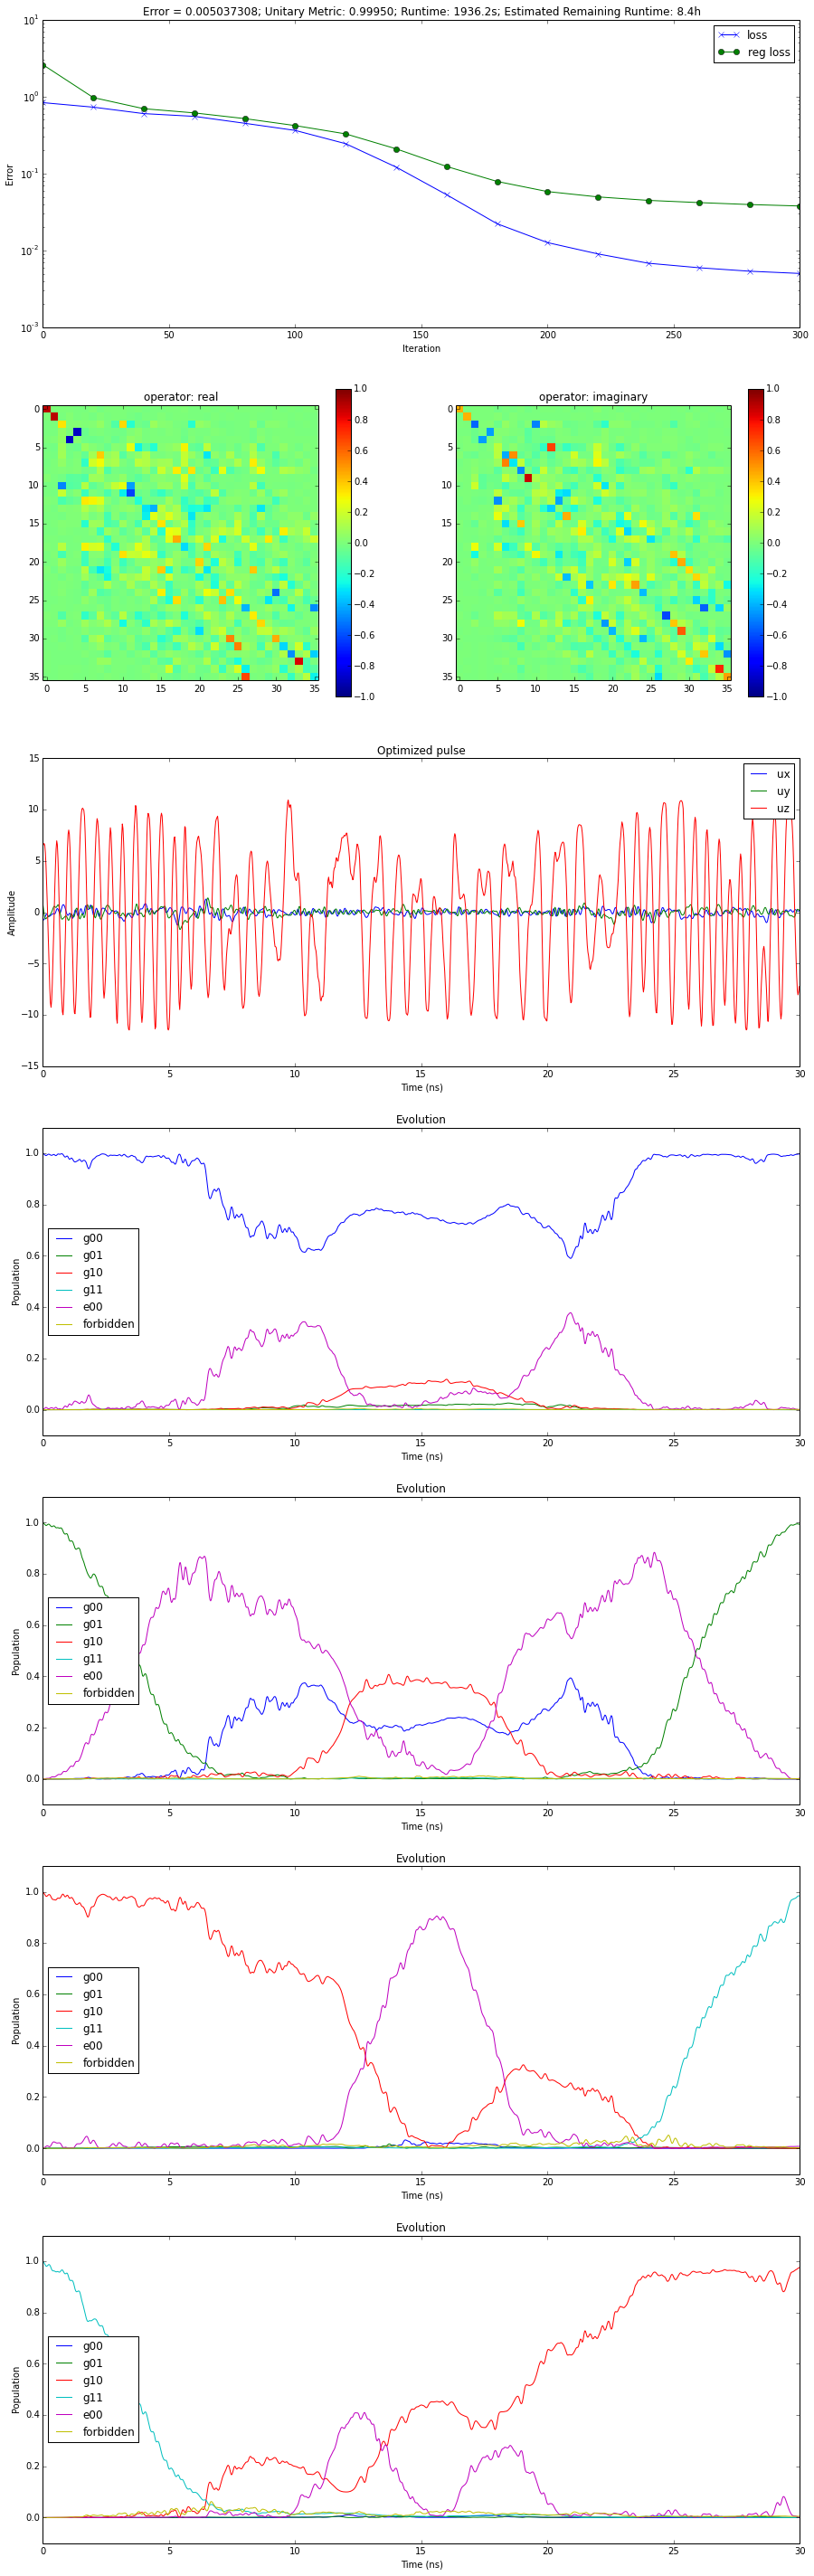

In [5]:
 #Extra options
#reg_coeffs = reg_coeffs,draw = [states_draw_list,states_draw_names] ,forbidden = states_forbidden_list,multi_mode = multi_mode,
#maxA = ops_max_amp,use_gpu = True
Grape(H0,Hops,Hnames,U,U0,total_time,steps,psi0,convergence, draw = [states_draw_list,states_draw_names],show_plots = True, maxA = ops_max_amp, 
      forbidden = states_forbidden_list, Unitary_error = 1e-6, multi_mode=multi_mode, reg_coeffs = reg_coeffs, method = 'BFGS')

## Operations to try

### Single Qubit
* Transmon Rotations (vs. level #)

### Multi-Qubit
* CZ
* CNOT
* Toffoli
* QFT

### Qubit - Cavity manipulation
* Qubit - cavity swap
* Number selective (2)pi pulse
* Number parity operator
* Create Cat state
* Create Cat code state
* Cat code single qubit rotation

### Multimode
* Qubit g-e rotations
* Qubit e-f rotations
* Qubit g-e mode swap
* Qubit mode CNOT
* Qubit mode CZ
* Mode-mode CNOT
* Mode-mode CZ
* Mode Parity
* Mode correlators
